## Redes Convolucionales - Tarea 2
#### Josmar Dominguez (16-10315)

#### Importación de librerías
A continuación se importan las librerías necesarias para trabajar en esta actividad.

In [1]:
import matplotlib.pyplot as plt         # To show dataset images
import pandas as pd                     # To manipulate dataframes
import torch                            # To create the convolutional neural network
from torch import nn                    # To create the architecture of the convolutional neural network
from torch.utils.data import DataLoader # To create the dataloader
from torch.nn import functional as F    # To use the activation functions
import torchvision                      # To manipulate the dataset
from torchvision import transforms

#### Importar dataset, visualizarlo y prepararlo
Se importa el datset empleando la librería ``torchvision.datasets``, y se crea un diccionario con las labels como clave, y el id como valor, y otro al revés. Para tener mayor facilidad al moomento de tener los resultados de la red.

In [2]:
# Create a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Dictionary of class names
labels = train_dataset.classes
label2id, id2label = {}, {}
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
print(f'{label2id=}')
print(f'{id2label=}')

Files already downloaded and verified
label2id={'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
id2label={0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


Luego, se muestran las imágenes, y un pequeño resumen sobre el dataset (*train*) para verificar que la información es correcta y coherente

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

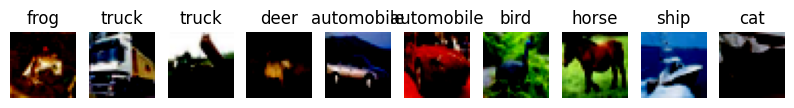

In [3]:
# Visualize the first 10 images
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(train_dataset[i][0].permute(1, 2, 0))
    # Add the label
    ax[i].set_title(id2label[train_dataset[i][1]])
plt.show()

train_dataset=Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


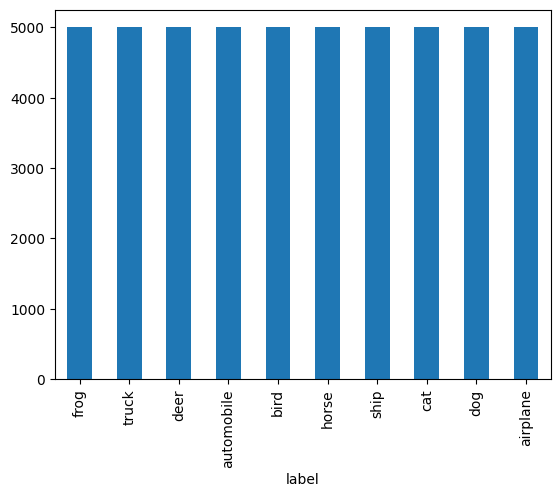

In [4]:
# Get a resume of datasets
print(f'{train_dataset=}')

# Get resume of train dataset (images for classes)
train_df = pd.DataFrame(train_dataset.targets, columns=['label'])
train_df['label'] = train_df['label'].apply(lambda x: id2label[x])
train_df['label'].value_counts().plot(kind='bar')
plt.show()

Se confirma que todas las clases tienen 5000 imágenes cada una, que coincide con la información de la documentación, en la que se explica que el dataset de entrenamiento tiene 5000 imágenes por clase, para un total de 50.000 imágenes.

In [5]:
batch_size = 64

# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Show the first batch
for images, labels in train_loader:
    print(f'{images.shape=}')
    print(f'{labels.shape=}')
    break

images.shape=torch.Size([64, 3, 32, 32])
labels.shape=torch.Size([64])


#### Creación de red neuronal
Se procede entonces a crear una clase para el modelo de la red neuronal, con una arquitectura que se pueda adaptar a las variables de entrada, y así adaptarlo a cualquier situación de manera eficaz y rápida.

In [19]:
# - Create the convolutional neural network -
class ConvNeuralNetwork(nn.Module):
    """
    Convolutional Neural Network Architecture
    to classify images from CIFAR-10 dataset.
    """

    def __init__(
        self,
        num_filters,
        kernel_size,
        num_layers,
        hidden_dim,
        dropout_prob,
        learning_decay,
        learning_rate=0.001,
        input_channels: int = 3,
        num_classes: int = 10,
    ):
        """
        Neural Network Architecture:
        - Convolutional Layer
        - ReLU Activation Function
        - Softmax Activation Function
        """
        super(ConvNeuralNetwork, self).__init__()
        # > Convolutional Layers
        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels=(
                        input_channels if i == 0 else num_filters * (2 ** (i - 1))
                    ),
                    out_channels=num_filters * (2**i),
                    kernel_size=kernel_size,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers)
            ]
        )

        self.output = nn.Linear(hidden_dim, num_classes)

        # > Activation Functions
        self.in_linear = num_filters * (2 ** (num_layers - 1)) * 4 * 4
        self.fc = nn.Linear(self.in_linear, hidden_dim)

        # > Dropout Layer
        self.dropout = nn.Dropout(dropout_prob)  # Dropout Layer to avoid overfitting

        # > Optimizer
        self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)

        # > Loss and cost function
        self.loss = nn.CrossEntropyLoss()
        self.actual_loss = 0
        self.cost = []
        
        self.actual_corrects = 0
        self.acc = []

        # > Learning decay (useless for now)
        self.learning_decay = learning_decay

        self.epochs_printed = []

    def forward(self, x: torch.Tensor, showImg=False) -> torch.Tensor:
        """
        Forward pass of the neural network.
        If showImg is True, make a plot with the output of each convolutional layer
        in a row.
        """
        
        rowImages = []
        
        for conv in self.convs:
            x = F.relu(conv(x))
            if showImg:
                rowImages.append(x.cpu())
            x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.in_linear)
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        x = self.output(x)
        
        # Show the images after the convolutional layers
        if showImg:
            fig, ax = plt.subplots(1, len(rowImages), figsize=(10, 1))
            for i in range(len(rowImages)):
                ax[i].set_axis_off()
                ax[i].imshow(rowImages[i][0][0].detach().numpy(), cmap="PRGn")
            plt.show()
        
        return x

    def backward(self, x: torch.Tensor, y: torch.Tensor, epoch: int) -> float:
        """
        Backward pass of the neural network.
        - Calculate the loss
        - Calculate the gradients
        - Update the weights
        """

        # Get the predictions
        y_pred = self.forward(x, showImg=epoch not in self.epochs_printed)
        self.epochs_printed.append(epoch)

        # Optimize the weights
        loss = self.loss(y_pred, y)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        # Take highest value as prediction
        _, y_pred = torch.max(y_pred, dim=1)
        self.actual_corrects += torch.sum(y_pred == y)

        # Accumulate the loss
        self.actual_loss += loss.item()

        return loss.item()

    def train(self, train_dataloader: DataLoader, epochs: int = 10) -> None:
        """
        Train the neural network.
        """
        for epoch in range(epochs):
            self.actual_loss = 0
            self.actual_corrects = 0
            
            for batch in train_dataloader:
                x, y = batch
                self.actual_loss += self.backward(x, y, epoch)

            self.acc.append(self.actual_corrects / (len(train_dataloader) * batch_size))
            self.cost.append(self.actual_loss / (len(train_dataloader) * batch_size))
            print(f"Epoch {epoch + 1} - Cost: {self.cost[-1]:.4f} | Acc: {self.acc[-1]:.4f}")



Con esto, se crea una instancia del modelo y se procede a entrenar

In [20]:
model = ConvNeuralNetwork(
    num_filters=16,
    kernel_size=3,
    num_layers=3,
    hidden_dim=500,
    dropout_prob=0.20,
    learning_rate=0.01,
    learning_decay=0.001
)

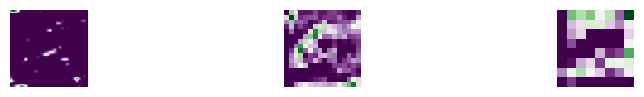

Epoch 1 - Cost: 0.0274 | Acc: 0.3547


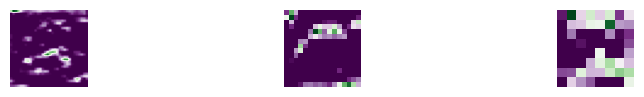

Epoch 2 - Cost: 0.0196 | Acc: 0.5504


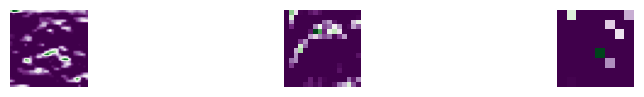

Epoch 3 - Cost: 0.0159 | Acc: 0.6408


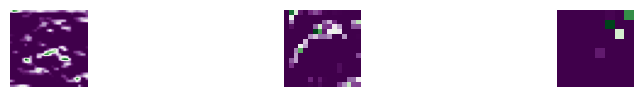

Epoch 4 - Cost: 0.0136 | Acc: 0.6927


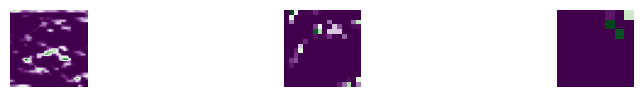

Epoch 5 - Cost: 0.0118 | Acc: 0.7348


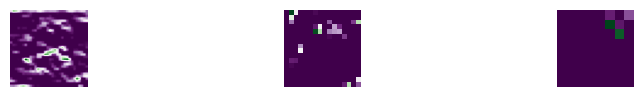

Epoch 6 - Cost: 0.0103 | Acc: 0.7652


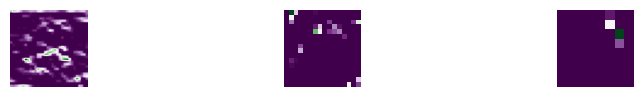

Epoch 7 - Cost: 0.0091 | Acc: 0.7932


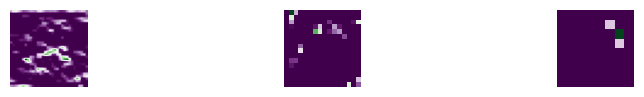

Epoch 8 - Cost: 0.0081 | Acc: 0.8178


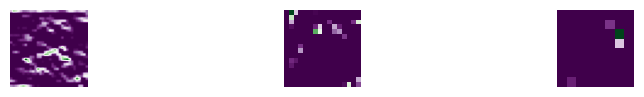

Epoch 9 - Cost: 0.0073 | Acc: 0.8346


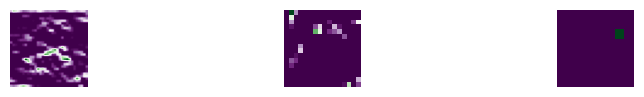

Epoch 10 - Cost: 0.0064 | Acc: 0.8527


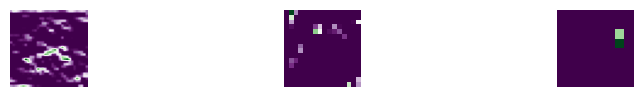

Epoch 11 - Cost: 0.0057 | Acc: 0.8673


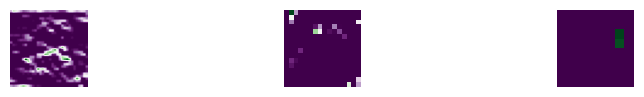

Epoch 12 - Cost: 0.0053 | Acc: 0.8775


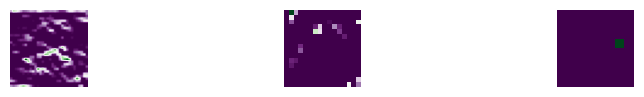

Epoch 13 - Cost: 0.0045 | Acc: 0.8962


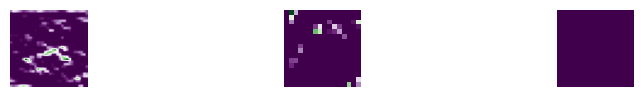

Epoch 14 - Cost: 0.0041 | Acc: 0.9063


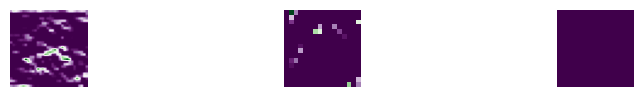

Epoch 15 - Cost: 0.0037 | Acc: 0.9164


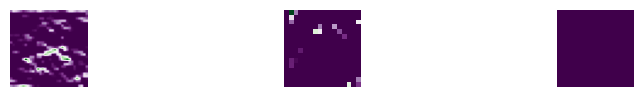

Epoch 16 - Cost: 0.0033 | Acc: 0.9247


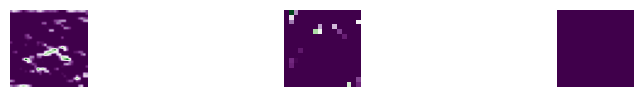

Epoch 17 - Cost: 0.0032 | Acc: 0.9258


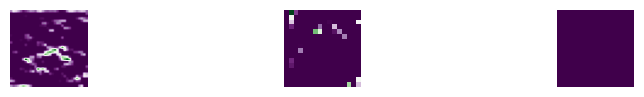

Epoch 18 - Cost: 0.0028 | Acc: 0.9360


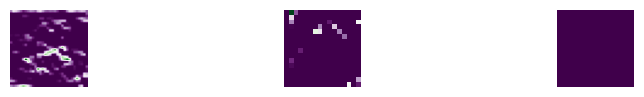

Epoch 19 - Cost: 0.0027 | Acc: 0.9398


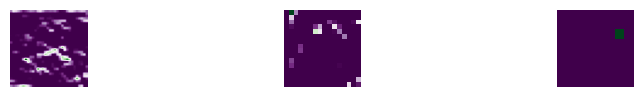

Epoch 20 - Cost: 0.0025 | Acc: 0.9416


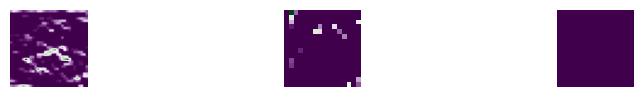

Epoch 21 - Cost: 0.0024 | Acc: 0.9452


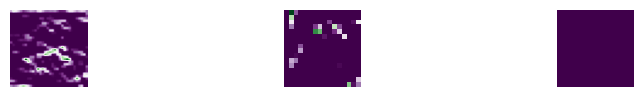

Epoch 22 - Cost: 0.0024 | Acc: 0.9464


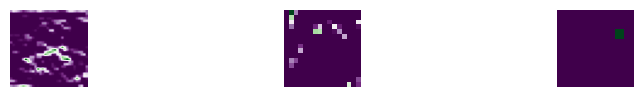

Epoch 23 - Cost: 0.0022 | Acc: 0.9507


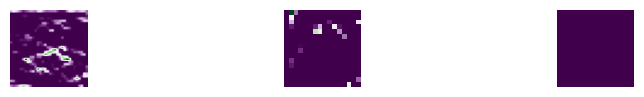

Epoch 24 - Cost: 0.0021 | Acc: 0.9536


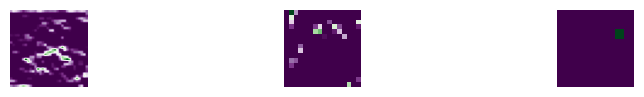

Epoch 25 - Cost: 0.0020 | Acc: 0.9576


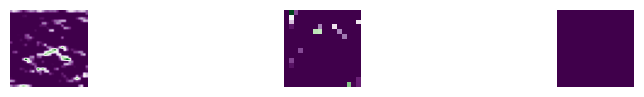

Epoch 26 - Cost: 0.0018 | Acc: 0.9583


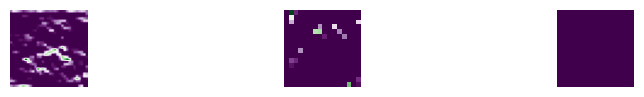

Epoch 27 - Cost: 0.0020 | Acc: 0.9563


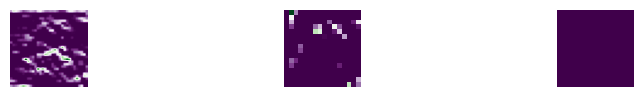

Epoch 28 - Cost: 0.0018 | Acc: 0.9600


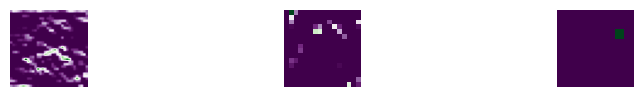

Epoch 29 - Cost: 0.0018 | Acc: 0.9600


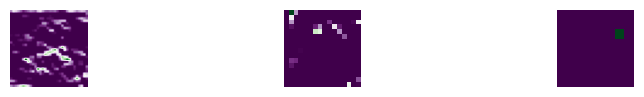

Epoch 30 - Cost: 0.0017 | Acc: 0.9632


In [21]:
model.train(train_loader, epochs=30)

### Análisis superficial de entrenamiento
Una vez entreanada la red, se observa la evolución del costo y el nivel de certeza del modelo.

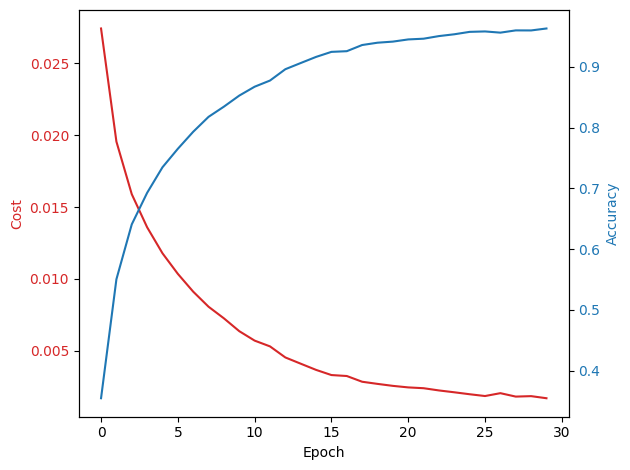

In [22]:
# Plot the cost and accuracy
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cost', color=color)
ax1.plot(model.cost, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(model.acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


### Exportación de red
Para poder emplear el modelo en otro documento para usarlo o evaluarlo, se exporta.

In [23]:
# Export the model
torch.save(model, 'cnn-cifar10.pt')